***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* 5. Imaging  
    * Previous: [5.2 Sampling functions and PSFs](2_sampling_functions_and_psfs.ipynb) 
    * Next: 5.3 The Dirty Image and Visibility Weights

***

In [5]:
#standard packages
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 5.3 Gridding and Degridding

In the previous section several sampling functions were presented. There the sampling functions were already neatly discretized into images, where each image was a grid of pixels all with the same size. Fourier inverting such regularly sampled data is done with the Fast Fourier Transform (FFT) algorithm, which operate in roughly $2N^2\log(N)$ steps instead of the normal $N^2M$ with $M\approx N^2$ complex exponentiations and multiplies that would be required in a direct approach, which calculates the intensity of each pixel:

\begin{equation}
 I(l,m) = \sum_{k=0}^{M-1}V_k(u,v)e^{2\pi i (lu+mv)}\text{, }V_k\text{ are the M measurements taken by the telescope}
\end{equation}

From this it should be clear that as the number of baselines or observation time is increased, the FFT approach would be far less time-consuming than the the direct approach. Unfortunately radio interferometers don't generally take measurements at regular intervals, and thus an FFT cannot be used on the observation data directly. Instead the data has to be *resampled* onto a grid with points spaced at regular intervals before taking the FFT. This resampling process and its inverse is the topic of this section.

A second problem related to using the FFT transform approach is that of aliasing. The FFT assumes that the input signal (here the spacial frequency domain) is periodic in nature. The resultant image constructed by resampling and inverse FFT therefore repeats at regular intervals: sources near the top of the image is aliased back into the image at the bottom for instance. This introduces the necessity to filter the image with a filter that only passes signal that falls inside the field of view being reconstructed. An example of this aliasing will be given later on.

### 5.3.1 The U,V plane

To start off the discussion on the resampling and image synthesis process let's consider a simulated JVLA observation. The JVLA has 27 reconfigurable antennae layouts. We will use the compact D configuration. The u,v coordinates depend on the observation hour angle, declination and wavelength.

TODO: generate some u,v coverage here

Luckily good coverage on the u,v plane (plane on which the measurements are taken) don't require physically moving the antennae while observing - as is evident from above. The Fourier relationship between the sky and the measurements taken by an interferometer depends on the orientation of the baseline vectors between antennae pairs relative to the sky, and these changes as the Earth rotates. As the earth rotates more samples are taken and the tracks swept out by each antenna pair increases in length. As the u,v coordinates are scaled by wavelength the individual tracks can be broadened by integrating many consequtive channels together. Both factors contribute to the accuracy of the reconstruction: as you've seen previously the more samples taken in the spacial frequency domain, the more accurately the original image can be reconstructed.

However, as is evident these samples do not fall at regularly spaced positions. The goal of *gridding* is to "interpolate" these samples onto regularly spaced grid positions. As you will see later some u,v space image deconvolution algorithms such as the Cotton-Schwab major-minor cycle algorithm requires that sources in image space are reconverted back into the non-regular measurement space. Here an accurate *degridding* operation is required to "interpolate" regularly sampled visibilities back onto the u,v tracks shown above.

###5.3.2 Gridding and Degridding

As you may suspect there are many ways to interpolate data to and from regular coordinates. The most widely used technique used in radio imaging programs, such as lwimager, is known as "convolutional-resampling". In this technique each visibility is weighted and smeared out onto grid points that lie within a small distance from the original coordinate.

The value at each grid point is a weighted accumulation of all the nearby visibilties. In one dimension this can be stated as:
\begin{equation}
 (\forall a \in \mathbb{Z}) f(a\Delta{x}) = \sum_{k\in Q\subset\mathbb{R}}f(k)C(a\Delta{x}-k)
\end{equation}

The weighting function, $C$ can be any of the miriad of functions proposed in the literature. These include linear, Lagrange, sinc (including one of the many windowing functions), Gaussian, modified B-spline, etc. 

You may have noticed that the interpolating function above is remarkably close to that of a discrete convolution. If the resampling was done on data that was regularly sampled and the convolution function evaluated at these regular discrete steps then the function would just the ordinary discrete convolution. However, the function as it stands is not quite a convolution, neither is it interpolation by the strictest definition of the word. Gridding and degridding should be thought of as *non-discrete integral convolution approximations*, but we will use the regular convolution notation for it in our discussion.

It is useful to think of these non-discrete convolution operations in terms of the ordinary up- and downsampling operations. In gridding, as with traditional upsampling the space in-between samples are filled with zero values. The only difference is that with gridding the original measurements are not regularly spaced, as would be the case with upsampling. Just as with ordinary upsampling it is then necessary to assign values to these new zero values in- between the measured values. With gridding the values are smeared out over the grid points within a some area of support.

TODO: gridding image here

With this understanding in hand we can define gridding and degridding more rigorously:
\begin{equation}
 \begin{split}
     V_\text{gridded}[u,v]&=[(V(u,v)S[u,v])*C(u,v)]III[u,v]\\
     V_\text{degridded}(u,v)&=[V_\text{gridded}[u,v]*C(u,v)]S[u,v]\\
 \end{split}
\end{equation}

In gridding the sampled visibilities are convolved with a convolution function then discretized onto regular points by the shah (bed-of-nails) function. In degridding the opposite is done: the regularly sampled discerete values are convolved and sampled along the sampling tracks in the u,v plane.

The convolution function, $C$, smears (gridding) and gathers (degridding) the visibilities over / from some area of support before discretizing the visibilities to new coordinates. Ideally this function would be computed during the gridding and degridding operations, however, considering that the processing costs of gridding and degridding both scale as $MC_\text{sup}^2$ these functions can be too computationally expensive to compute for every visibility and is normally pretabulated for a given support size. Additionally it is important to sample this function much more densely than the spacings between grid cells; interferometers take measurements in the spatial frequency domain and any large snapping / rounding operation on the coordinates of the samples will result in a decorrelation in the structural information about the image. The figure below illustrates how values are picked from the oversampled filter.

TODO: Illustration here

In addition to accuracy the alias-reduction properties of the convolution filter, $C$ being used is essential to the FFT approach. By the convolution relation the reconstructed image of the radio sky can be stated as follows:
\begin{equation}
I_\text{dirty}[l,m] = ([I(l,m)*\text{PSF}(l,m)]c(l,m))*\mathscr{F}[III(u,v)](l,m)
\end{equation}

Convolution with the fourier transform of the shah function (a series of periodic functions in the image domain) replicates the field of view at a period of $M\text{cell}_l$ and $N\text{cell}_m$ for an $M\times N$ pixel image, and it is this undesirable replication that must be stopped. To that end one would hope that the fourier transform of the convolution filter, $c(l,m)$, maximizes the following ratio:
\begin{equation}
\frac{\int_\text{FOV}|c(l,m)|^2dS}{\int_{-\infty}^\infty|c(l,m)|^2dS}
\end{equation}

Simply stated it is desirable that the function $c$ is only non-zero over a small central region, the field of view.

Both the remarks about accuracy and fourier response precludes using a nearest neighbour approach to interpolating points to and from regular coordinates. This technique (also known as *cell-summing*) simply accumulates the neighbouring points that fall within a rectangular region around the new coordinate, without considering the distance those points are from the new coordinate. The fourier-response to this box function is an infinite sinc function, which ripples out slowly to infinity and doesn't stop much of the aliasing energy. Convolutional gridding/degridding is therefore a more attractive approach to such a cell-summing algorithm, because the distance between the grid point and the measured uv point is taken into account when selecting a set of convolution weights.

The observation about the fourier response of the box function leads us to a partial solution for the aliasing problem, in that the fourier reponse to convolving with an *infinite* sinc will yield a box response. Unfortunately this is not computationally feasible and instead the best option is to convolve with a windowed sinc function, or some other function that has a similar centre-heavy fourier response, which preferably tapers off reasonably quickly. The images below illustrates the significant improvement using a truncated sinc function compared to nearest-neighbour interpolation.

TODO: Aliased/non-aliased grid patterns here

Below the magnitude of the sidelobes of the fourier responses are plotted. The response of the box function is significantly higher than that of a truncated and windowed sinc functions.

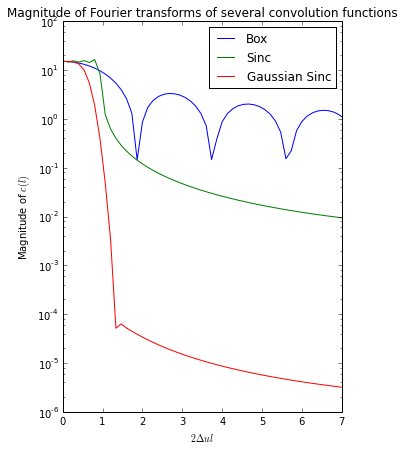

In [161]:
half_sup = 6
oversample = 15
full_sup = (half_sup * 2 + 1) + 2 #+ padding
no_taps = full_sup + (full_sup - 1) * (oversample - 1)
taps = np.arange(-no_taps//2,no_taps//2 + 1)/float(oversample)

#unit box
box = np.where((taps >= -0.5) & (taps <= 0.5),
               np.ones([len(taps)]),np.zeros([len(taps)]))
fft_box=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(box))))
#truncated (boxed) sinc
sinc = np.sinc(taps)
fft_sinc=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinc))))
#gaussian sinc
alpha_1=1.55
alpha_2=2.52
gsinc = np.sin(np.pi/alpha_1*(taps+0.00000000001))/(np.pi*(taps+0.00000000001))*np.exp(-(taps/alpha_2)**2)
fft_gsinc=np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(gsinc))))
#plot it up
plt.figure(figsize=(5, 7), dpi=80)
l = np.arange(-(no_taps)//2,(no_taps)//2+1) * (1.0/oversample)
a, = plt.plot(2*l,fft_box)
b, = plt.plot(2*l,fft_sinc)
c, = plt.plot(2*l,fft_gsinc)
ax = plt.gca()
ax.set_xlim(0,no_taps//2 * (1.0/oversample))
ax.set_yscale("log", nonposy='clip')
plt.legend([a,b,c],["Box","Sinc","Gaussian Sinc"])
plt.xlabel("$2\Delta{u}l$")
plt.ylabel("Magnitude of $c(l)$")
plt.title("Magnitude of Fourier transforms of several convolution functions")
plt.show()

After fourier transformation the effects of the convolution function on the image can be mitigated by point-wise dividing the image through by the fourier transform of the convolution function, $c(l,m)$. This has the effect of flattening the response of the passband, by removing the tapering towards the edges of the image, but raises the amplitude of any aliased sources at the edge of the image.

In practice the proloid spheriodal functions are used in imaging programs such as lwimager, but the definition of these functions are beyond the scope of the introductory discussion here and the reader is referred to the work of Donald Rhodes (TODO REF) for a detailed discussion of their definition and proof of their aliasing reduction properties.

It is also worth noting that the convolution functions used in gridding and degridding need not be the same function. In degridding the focus is solidly on the accuracy of the predicted visibility. Here it can be advantageous to minimize the difference between a direct transformation approach and a Fast Fourier Transform approach with degridding, see for instance Sze Tan's discussion on the topic for further detail. 

### 5.3.3 Example simulator and imager

***

* Next: 5.3 The Dirty Image and Visibility Weights

***